# CNN Featurizers and Similarity Search
### Julian Hame - jsh38

### Introduction
Typically when we train a Convolutional Neural Network as an end-to-end image classifier, we input an image to the network, which gets propagated through the network (feed forward).

We then obtain our posterior probabilities at the end of the network.

However, there is no “rule” that says we must allow the image to forward propagate through the entire network that includes the head. Instead, we can:

1) Stop propagation at a layer before the head of the network (such as an activation or pooling layer).

2) Extract the logits at this layer.

3) Treat the values as a feature vector.

Now these feature vectors can be utilized in other downstream tasks like classification. Our aim is to create a system where an input query image will be responded by a number of  images that have strong resemblance to the query image. This particular task is called **similarity search**. A naive way to perform this task, would be to compare images based on pixel values, patches, or some other high level feature taken from the image itself. You are askd to use the ResNet-50 architecture to produce features that can represent a concept aka a face with specific characteristics. 

### Part 1 Loading of Dataset in Colab (10 points)

Create a jupyter notebook (eg on Google Colab) and download the LFW dataset, from [here](http://vis-www.cs.umass.edu/lfw/).

You can manually download the dataset using the above link and then upload to colab or altelnatively you can issue in colab the commands shown below


In [3]:
# Load dataset in Colab
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xvf /content/lfw.tgz

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Ai

### Part 2 Using CNN for Feature Extraction (30 points)

Use ResNet50 to extract features vectors from raw images. You can use TF or Pytorch APIs to: 

* Obtain a ResNet-50  model pre-trained on a dataset such as ImageNet. 
* Perform necessary preprocessing on the images before feeding them into the network.
* Extract the features from the penultimate layer of the network (before the fully connected layer - the classification head).
* Store the features in a dictionary, where the key is the name of the image and the value is the feature vector.


In [7]:
# Importing necessary modules
import numpy as np
from numpy.linalg import norm
import os
import time
import pickle
from tqdm import tqdm, tqdm_notebook
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [8]:
# Obtaining ResNet-50 trained on ImageNet
model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))

# Image preprocessing
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [9]:
# Obtain image filenames
extensions = ['.jpg']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

In [10]:
# Path to the datasets
root_dir = '../../content/lfw'
filenames = sorted(get_file_list(root_dir))

In [85]:
# Extract features to dictionary
feature_dict = {}
#for img in tqdm_notebook(range(len(filenames))):
for img in tqdm_notebook(range(len(filenames)-12000)):
    feature_dict[filenames[img]] = extract_features(filenames[img], model)

<ipython-input-85-6c0ef4ea30cd>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm_notebook(range(len(filenames)-12000)):


  0%|          | 0/1233 [00:00<?, ?it/s]

1/1 [==============================] - 0s 209ms/step


In [86]:
# Store data into pickle file
pickle.dump(feature_dict, open('feature_dict.pickle', 'wb'))

In [3]:
# Retrieve data from pickle file
import pickle
feature_dict = pickle.load(open('feature_dict.pickle', 'rb'))

### Part 3 Retrieving most similar images (30 points)

Use a nearest neighbor algorithm such as [this](https://scikit-learn.org/stable/modules/neighbors.html) to obtain the 10 most similar images to each query image. 


In [51]:
# Prompt user for query image
query_image = int(input("Enter the ID number of an image (1-1232): "))

Enter the ID number of an image (1-1232): 1


In [53]:
# Turn image locations into actual person and image names
person_names = []
image_names = []

x = 0
while x < len(filenames):
  split_name = filenames[x].split('/')
  person_names.append(split_name[4].replace("_", " "))
  image_names.append(split_name[5])
  x = x + 1

Your Image
----------------------------------------
Person:   AJ Lamas
Filename: AJ_Lamas_0001.jpg



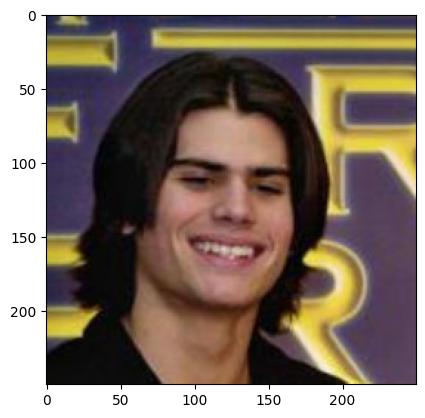

In [55]:
# Display query image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print("Your Image")
print("----------------------------------------")
print("Person:   " +person_names[query_image])
print("Filename: " +image_names[query_image])
print("")
plt.imshow(mpimg.imread(filenames[query_image]))

In [59]:
# Turn feature vectors of dictionary into a 2D list that can be fed into NN algorithm
feature_list = list(feature_dict.values())

x = 0
while x < len(feature_list):
  feature_list[x] = list(feature_list[x])
  x = x + 1

In [60]:
# Nearest Neighbor Algorithm
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=11, algorithm='brute',
metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors([feature_list[query_image]])

Most Similar:
----------------------------------------
Person:   Alanna Ubach
Filename: Alanna_Ubach_0001.jpg



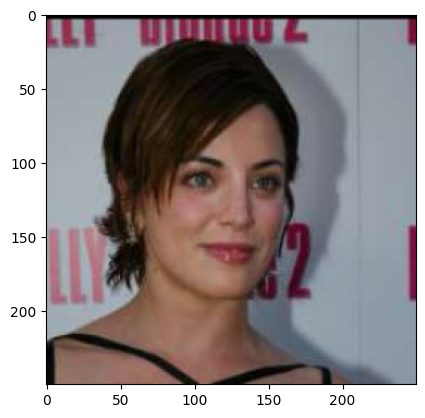

In [56]:
# Display most similar image
print("Most Similar:")
print("----------------------------------------")
print("Person:   " +person_names[list(indices[0])[1]])
print("Filename: " +image_names[list(indices[0])[1]])
print("")
plt.imshow(mpimg.imread(filenames[list(indices[0])[1]]))

2nd Most Similar:
----------------------------------------
Person:   Bernice Wong
Filename: Bernice_Wong_0001.jpg



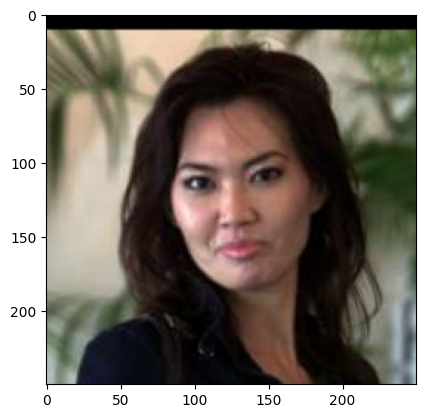

In [57]:
# Display second most similar image
print("2nd Most Similar:")
print("----------------------------------------")
print("Person:   " +person_names[list(indices[0])[2]])
print("Filename: " +image_names[list(indices[0])[2]])
print("")
plt.imshow(mpimg.imread(filenames[list(indices[0])[2]]))

3rd Most Similar:
----------------------------------------
Person:   Anita DeFrantz
Filename: Anita_DeFrantz_0001.jpg



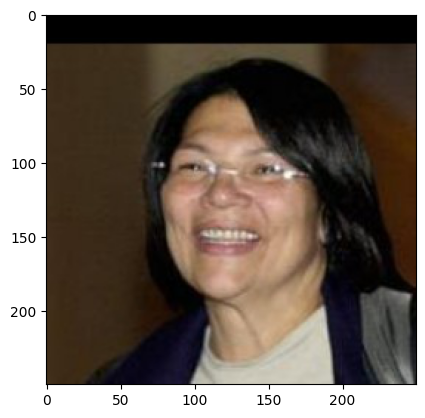

In [58]:
# Display third most similar image
print("3rd Most Similar:")
print("----------------------------------------")
print("Person:   " +person_names[list(indices[0])[3]])
print("Filename: " +image_names[list(indices[0])[3]])
print("")
plt.imshow(mpimg.imread(filenames[list(indices[0])[3]]))

4th Most Similar:
----------------------------------------
Person:   Andre Agassi
Filename: Andre_Agassi_0014.jpg



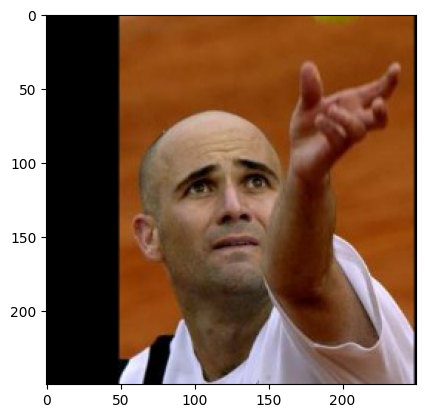

In [42]:
# Display fourth most similar image
print("4th Most Similar:")
print("----------------------------------------")
print("Person:   " +person_names[list(indices[0])[4]])
print("Filename: " +image_names[list(indices[0])[4]])
print("")
plt.imshow(mpimg.imread(filenames[list(indices[0])[4]]))

5th Most Similar:
----------------------------------------
Person:   Aitor Gonzalez
Filename: Aitor_Gonzalez_0001.jpg



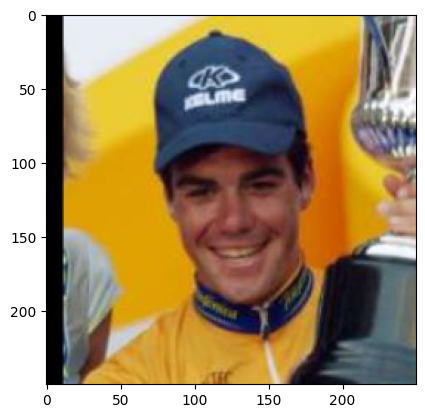

In [43]:
# Display fifth most similar image
print("5th Most Similar:")
print("----------------------------------------")
print("Person:   " +person_names[list(indices[0])[5]])
print("Filename: " +image_names[list(indices[0])[5]])
print("")
plt.imshow(mpimg.imread(filenames[list(indices[0])[5]]))

6th Most Similar:
----------------------------------------
Person:   Antonio Trillanes
Filename: Antonio_Trillanes_0002.jpg



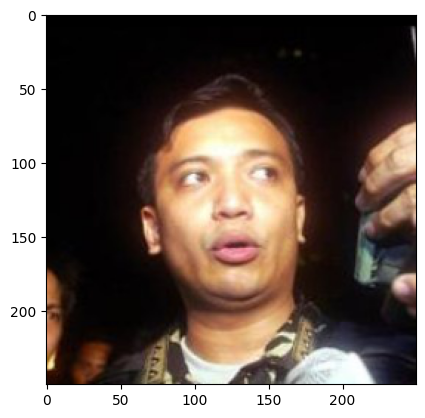

In [44]:
# Display sixth most similar image
print("6th Most Similar:")
print("----------------------------------------")
print("Person:   " +person_names[list(indices[0])[6]])
print("Filename: " +image_names[list(indices[0])[6]])
print("")
plt.imshow(mpimg.imread(filenames[list(indices[0])[6]]))

7th Most Similar:
----------------------------------------
Person:   Andy Roddick
Filename: Andy_Roddick_0001.jpg



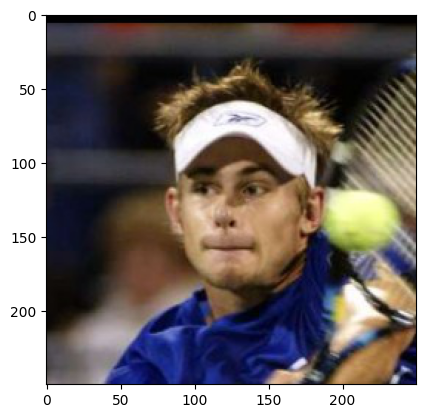

In [45]:
# Display seventh most similar image
print("7th Most Similar:")
print("----------------------------------------")
print("Person:   " +person_names[list(indices[0])[7]])
print("Filename: " +image_names[list(indices[0])[7]])
print("")
plt.imshow(mpimg.imread(filenames[list(indices[0])[7]]))

8th Most Similar:
----------------------------------------
Person:   Amelie Mauresmo
Filename: Amelie_Mauresmo_0014.jpg



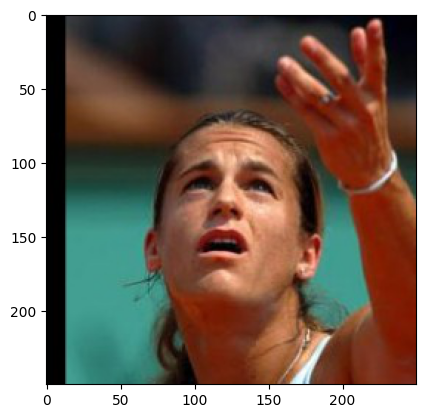

In [46]:
# Display eighth most similar image
print("8th Most Similar:")
print("----------------------------------------")
print("Person:   " +person_names[list(indices[0])[8]])
print("Filename: " +image_names[list(indices[0])[8]])
print("")
plt.imshow(mpimg.imread(filenames[list(indices[0])[8]]))

9th Most Similar:
----------------------------------------
Person:   Allen Iverson
Filename: Allen_Iverson_0002.jpg



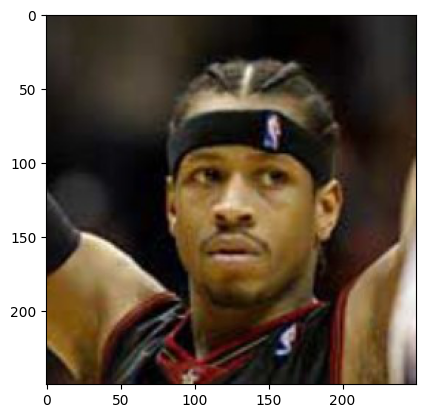

In [47]:
# Display ninth most similar image
print("9th Most Similar:")
print("----------------------------------------")
print("Person:   " +person_names[list(indices[0])[9]])
print("Filename: " +image_names[list(indices[0])[9]])
print("")
plt.imshow(mpimg.imread(filenames[list(indices[0])[9]]))

10th Most Similar:
----------------------------------------
Person:   Alexandre Vinokourov
Filename: Alexandre_Vinokourov_0001.jpg



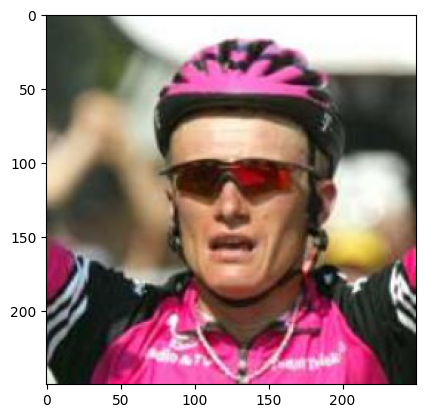

In [48]:
# Display tenth most similar image
print("10th Most Similar:")
print("----------------------------------------")
print("Person:   " +person_names[list(indices[0])[10]])
print("Filename: " +image_names[list(indices[0])[10]])
print("")
plt.imshow(mpimg.imread(filenames[list(indices[0])[10]]))

## Part 4 - Streamlit App (30 points)

See [this example app](https://github.com/georgestein/galaxy_search) and develop an app that will showcase the similarity search system you have developed. The app should offer two possibiities: select an image from the test dataset and upload an image. It should then display the 10 most similar images to the query image. **The app must be deployed to a Streamlit space in Hugging Face.** 